In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import tensorflow as tf
from collections import Counter

from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from scikeras.wrappers import KerasRegressor

from tensorflow.keras.utils import to_categorical
from keras import models
from keras import layers
from time import time

from datetime import datetime
import pickle
import warnings
warnings.filterwarnings("ignore")

In [64]:
train_df = pd.read_csv('train-Cirrhosis Outcomes.csv', encoding='iso-8859-1')
valid_df = pd.read_csv('valid- Cirrhosis Outcomes.csv', encoding='iso-8859-1')
train_df.isnull().any()

id               False
N_Days           False
Drug             False
Age              False
Sex              False
Ascites          False
Hepatomegaly     False
Spiders          False
Edema            False
Bilirubin        False
Cholesterol      False
Albumin          False
Copper           False
Alk_Phos         False
SGOT             False
Tryglicerides    False
Platelets        False
Prothrombin      False
Stage            False
Status           False
dtype: bool

In [52]:
train_df.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [4]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,7905.0,3952.000000,2282.121272,0.00,1976.00,3952.00,5928.00,7904.00
N_Days,7905.0,2030.173308,1094.233744,41.00,1230.00,1831.00,2689.00,4795.00
Age,7905.0,18373.146490,3679.958739,9598.00,15574.00,18713.00,20684.00,28650.00
Bilirubin,7905.0,2.594485,3.812960,0.30,0.70,1.10,3.00,28.00
Cholesterol,7905.0,350.561923,195.379344,120.00,248.00,298.00,390.00,1775.00
Albumin,7905.0,3.548323,0.346171,1.96,3.35,3.58,3.77,4.64
Copper,7905.0,83.902846,75.899266,4.00,39.00,63.00,102.00,588.00
Alk_Phos,7905.0,1816.745250,1903.750657,289.00,834.00,1181.00,1857.00,13862.40
SGOT,7905.0,114.604602,48.790945,26.35,75.95,108.50,137.95,457.25
Tryglicerides,7905.0,115.340164,52.530402,33.00,84.00,104.00,139.00,598.00


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   object 
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   object 
 5   Ascites        7905 non-null   object 
 6   Hepatomegaly   7905 non-null   object 
 7   Spiders        7905 non-null   object 
 8   Edema          7905 non-null   object 
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

In [6]:
train_df['Status'].value_counts()

Status
C     4965
D     2665
CL     275
Name: count, dtype: int64

In [65]:
names = ['Ascites', 'Hepatomegaly', 'Spiders', 'Edema',]
for name in names:
    train_df[name] = train_df[name].apply(lambda x: -1 if 'S' == x else (0 if 'N' == x else 1))
    valid_df[name] = valid_df[name].apply(lambda x: -1 if 'S' == x else (0 if 'N' == x else 1))
train_df.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,0,0,0,0,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,0,0,0,0,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,0,1,1,1,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,0,0,0,0,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,0,1,0,0,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [66]:
names = ['Sex',]
for name in names:
    train_df[name] = train_df[name].apply(lambda x: 1 if 'M' == x else 0)
    valid_df[name] = valid_df[name].apply(lambda x: 1 if 'M' == x else 0)

In [67]:
names = ['Drug',]
for name in names:
    train_df[name] = train_df[name].apply(lambda x: 1 if 'D-penicillamine' == x else 0)
    valid_df[name] = valid_df[name].apply(lambda x: 1 if 'D-penicillamine' == x else 0)

<Axes: >

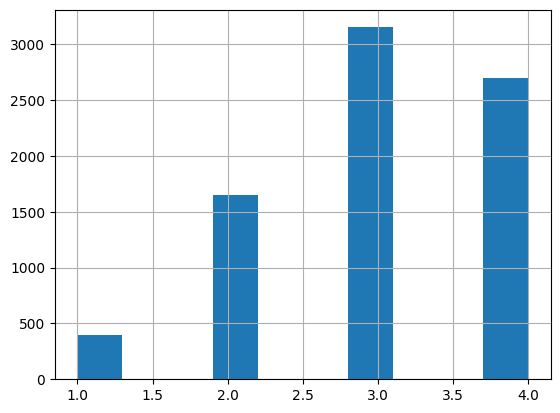

In [31]:
train_df['Stage'].hist()

In [68]:
train_points = train_df.drop(['Status', 'id'], axis=1)
train_values = train_df['Status']

test_points = valid_df.drop(['id'], axis=1)
test_values_df = pd.read_csv('Output-Prediction of Cirrhosis Outcomes.csv', encoding='iso-8859-1')
test_values_df['Status'] = ""
for index, row in test_values_df.iterrows():
    test_values_df.loc[index, 'Status'] = 'C' if row['Status_C'] > row['Status_CL'] and row['Status_C'] > row['Status_D'] else ('CL' if row['Status_CL'] > row['Status_D'] else 'D')

test_values = test_values_df['Status']

In [16]:
train_points.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,999,1,21532,1,0,0,0,0,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0
1,2574,0,19237,0,0,0,0,0,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0
2,3428,0,13727,0,0,1,1,1,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0
3,2576,0,18460,0,0,0,0,0,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0
4,788,0,16658,0,0,1,0,0,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0


In [57]:
test_values.head()

0    C
1    C
2    D
3    C
4    C
Name: Status, dtype: object

In [36]:
rf_model = ensemble.RandomForestClassifier(n_estimators=30)
rf_model.fit(train_points, train_values)
test_predict_rf = rf_model.predict(test_points)
accuracy = accuracy_score(test_values, test_predict_rf)
print(accuracy)

0.8871181938911022


In [58]:
filename = f'models/{accuracy}-RandomForest.sav'
with open(filename, 'wb') as f:
    pickle.dump(rf_model, f)

In [37]:
rf_model = pickle.load(open('models/0.8810472396129767-RandomForest.sav', 'rb'))

start = time()
test_predict_rf = rf_model.predict(test_points)
end = time()
accuracy = accuracy_score(test_values, test_predict_rf)
print(f'{end - start:.3f}')
print(accuracy)

0.018
0.8810472396129767


In [17]:
train_points.describe().T

,count,mean,std,min,25%,50%,75%,max
N_Days,7905.0,2030.173308,1094.233744,41.00,1230.00,1831.00,2689.00,4795.00
Drug,7905.0,0.492726,0.499979,0.00,0.00,0.00,1.00,1.00
Age,7905.0,18373.146490,3679.958739,9598.00,15574.00,18713.00,20684.00,28650.00
Sex,7905.0,0.071980,0.258471,0.00,0.00,0.00,0.00,1.00
Ascites,7905.0,0.048071,0.213929,0.00,0.00,0.00,0.00,1.00
Hepatomegaly,7905.0,0.511322,0.499903,0.00,0.00,1.00,1.00,1.00
Spiders,7905.0,0.245288,0.430285,0.00,0.00,0.00,0.00,1.00
Edema,7905.0,-0.006831,0.306729,-1.00,0.00,0.00,0.00,1.00
Bilirubin,7905.0,2.594485,3.812960,0.30,0.70,1.10,3.00,28.00
Cholesterol,7905.0,350.561923,195.379344,120.00,248.00,298.00,390.00,1775.00


In [69]:
columns = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
for name in columns:
    train_points[f'Normalize{name}'] = train_points[name] / np.max(train_df[name])
    del train_points[name]
    
    test_points[f'Normalize{name}'] = test_points[name] / np.max(train_df[name])
    del test_points[name]
train_points.head()

,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Albumin,Stage,NormalizeN_Days,NormalizeAge,NormalizeBilirubin,NormalizeCholesterol,NormalizeCopper,NormalizeAlk_Phos,NormalizeSGOT,NormalizeTryglicerides,NormalizePlatelets,NormalizeProthrombin
0,1,1,0,0,0,0,3.35,3.0,0.208342,0.751553,0.082143,0.178028,0.292517,0.115492,0.393220,0.105351,0.699822,0.538889
1,0,0,0,0,0,0,3.54,3.0,0.536809,0.671449,0.032143,0.205070,0.107143,0.103878,0.294915,0.147157,0.641208,0.611111
2,0,0,0,1,1,1,3.55,4.0,0.714911,0.479127,0.117857,0.168451,0.222789,0.074230,0.261017,0.083612,0.353464,0.650000
3,0,0,0,0,0,0,3.50,3.0,0.537226,0.644328,0.021429,0.144225,0.098639,0.119243,0.155932,0.160535,0.477798,0.594444
4,0,0,0,1,0,0,3.65,4.0,0.164338,0.581431,0.039286,0.194930,0.107143,0.085194,0.274576,0.160535,0.529307,0.588889


In [32]:
columns = ['Ascites','Spiders']
for name in columns:
    del train_points[name]
    del test_points[name]

In [77]:
train_values = train_values.apply(lambda x: 0 if x == 'C' else 1 if x == 'CL' else 2)
test_values = test_values.apply(lambda x: 0 if x == 'C' else 1 if x == 'CL' else 2)

In [60]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
test_values = lb.fit_transform(test_values)
train_values = lb.fit_transform(train_values)

In [43]:
train_points['NormNumOfProducts'] = train_points.apply(lambda x: 1 if x['NumOfProducts'] > 2 else 0, axis=1)
del train_points['NumOfProducts']
test_points['NormNumOfProducts'] = test_points.apply(lambda x: 1 if x['NumOfProducts'] > 2 else 0, axis=1)
del test_points['NumOfProducts']

In [80]:
train_points.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Drug                    7905 non-null   int64  
 1   Sex                     7905 non-null   int64  
 2   Ascites                 7905 non-null   int64  
 3   Hepatomegaly            7905 non-null   int64  
 4   Spiders                 7905 non-null   int64  
 5   Edema                   7905 non-null   int64  
 6   Albumin                 7905 non-null   float64
 7   Stage                   7905 non-null   float64
 8   NormalizeN_Days         7905 non-null   float64
 9   NormalizeAge            7905 non-null   float64
 10  NormalizeBilirubin      7905 non-null   float64
 11  NormalizeCholesterol    7905 non-null   float64
 12  NormalizeCopper         7905 non-null   float64
 13  NormalizeAlk_Phos       7905 non-null   float64
 14  NormalizeSGOT           7905 non-null   

In [83]:
print(max(test_points.count(axis='columns')))

18


In [22]:
count = max(train_points.count(axis='columns'))
model = models.Sequential()

model.add(layers.Dense(count, activation = "elu"))

model.add(layers.Dense(count * 2, activation = "relu"))

model.add(layers.Dense(count, activation = "relu"))

model.add(layers.Dense(3, activation = "softmax"))

model.compile(
 optimizer = "adam",
 loss = "sparse_categorical_crossentropy",
 metrics = ["accuracy"]
)


In [ ]:
results = model.fit(
 train_points, train_values,
 epochs= 10,
 batch_size = 10,
 validation_data = (test_points, test_values)
)
print("Test-Accuracy:", np.max(results.history["accuracy"]))

In [71]:
def simple_model():                                           
    # create model
    count = max(train_points.count(axis='columns'))
    model = models.Sequential()
    model.add(layers.Dense(count, activation = "elu"))
    model.add(layers.Dense(count * 2, activation = "relu"))
    model.add(layers.Dense(count, activation = "relu"))
    model.add(layers.Dense(3, activation = "softmax"))
    model.compile(
        optimizer = "adam",
        loss = "sparse_categorical_crossentropy",
        metrics = ["accuracy"]
    )
    return model

In [79]:
ann_estimator = KerasRegressor(build_fn= simple_model, epochs=100, batch_size=10, verbose=0)
boosted_ann = AdaBoostRegressor(base_estimator= ann_estimator)
boosted_ann.fit(train_points, train_values)# scale your training data 
result = boosted_ann.predict(test_points)


TypeError: object of type 'NoneType' has no len()

In [40]:
start = time()
test_predict_rf = model.predict(test_points)
end = time()
accuracy = accuracy_score(test_values, test_predict_rf)
print(f'{end - start:.3f}')
print(accuracy)

0.027
0.0


In [41]:
accuracy = np.max(results.history["accuracy"])
filename = f'models/{accuracy}-NN.keras'
model.save(filename)

In [55]:
accuracy = 89.2
timeSec = 0.003
total=(1.25 * (accuracy / 100) * ((5-timeSec)/5 if timeSec<5 else 0))/(0.25 * (accuracy / 100) + ((5-timeSec)/5 if timeSec<5 else 0))
print(total)

0.9115927683246073
